15:47:11 - cmdstanpy - INFO - Chain [1] start processing
15:47:11 - cmdstanpy - INFO - Chain [1] done processing


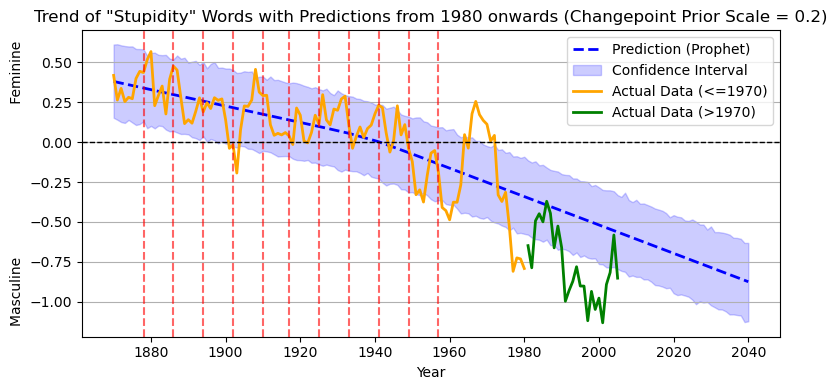

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import numpy as np

positive_words = ['she', 'her', 'her', 'women', 'mother', 'daughter', 'sister', 'female']
negative_words = ['he', 'his', 'him', 'man', 'men', 'father', 'son', 'brother', 'male']
target_word = "stupid_foolish_fool"
file_name = f'results/5000_{target_word}_{",".join(negative_words[:3])}_{",".join(positive_words[:3])}.csv'

try:
    result = pd.read_csv(file_name)
except FileNotFoundError:
    print(f"CSV file not found: {file_name}")
    exit()

columns_to_drop = [f'Year_{year}' for year in range(1825, 1870)]
result = result.drop(columns=[col for col in columns_to_drop if col in result.columns], errors='ignore')

# Extract years and data for each year
year_columns = [col for col in result.columns if col.startswith('Year_')]
years = [int(col.split('_')[1]) for col in year_columns]
mean_values = result[year_columns].mean()

# Prepare data for Prophet
df = pd.DataFrame({'ds': years, 'y': mean_values.values})
df['ds'] = pd.to_datetime(df['ds'], format='%Y')  # Convert to datetime format with years only
predict_year = 1980
# Split data for plotting
actual_before_1960 = df[df['ds'].dt.year <= predict_year]
actual_after_1960 = df[df['ds'].dt.year > predict_year]

# Fit Prophet model with a maximum of 10 changepoints
changepoint_prior_scale = 0.2
model = Prophet(
    yearly_seasonality=False,
    daily_seasonality=False,
    n_changepoints=11, 
    changepoint_prior_scale=changepoint_prior_scale,
)

# model.add_seasonality(
#     name='decade',
#     period=10,             # 10 years
#     fourier_order=3,       # Adjust as needed
#     prior_scale=5.0       # Adjust as needed
# )
model.fit(actual_before_1960)

# Make future DataFrame for prediction
future = model.make_future_dataframe(periods=60, freq='Y')  # Predict 30 years into the future
forecast = model.predict(future)

# Plot the forecast with actual data
plt.figure(figsize=(8, 4))

plt.plot(forecast['ds'], forecast['yhat'], label='Prediction (Prophet)', linestyle='--', color='blue', linewidth=2)

plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    alpha=0.2,
    color='blue',
    label='Confidence Interval'
)

# Plot actual data before and after 1960
plt.plot(actual_before_1960['ds'], actual_before_1960['y'], label='Actual Data (<=1970)', color='orange', linewidth=2)
plt.plot(actual_after_1960['ds'], actual_after_1960['y'], label='Actual Data (>1970)', color='green', linewidth=2)

# Highlight changepoints
for changepoint in model.changepoints:
    plt.axvline(changepoint, color='red', linestyle='--', alpha=0.6)

# Set up the axes, labels, and legend
plt.title(f'Trend of "Stupidity" Words with Predictions from {predict_year} onwards (Changepoint Prior Scale = {changepoint_prior_scale})')
plt.ylabel(f'Masculine                                   Feminine')
plt.xlabel('Year')
plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Highlight y=0 line
#plt.xticks(range(1870, 2020, 10))  # Set x-ticks every 10 years
plt.legend(fontsize='medium', loc='best')
plt.grid(axis='y')

# Save the figure
plt.tight_layout()
plt.savefig(f'results/prediction_vs_actual_split_{target_word}.png')

# Show the plot
plt.show()


/Users/maxzhu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/maxzhu/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


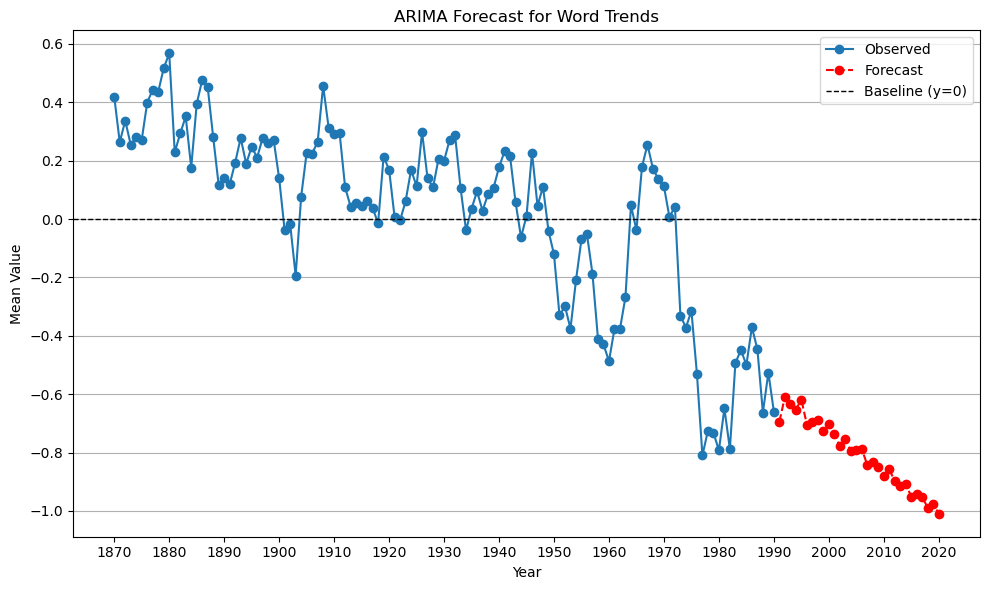

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  121
Model:                ARIMA(5, 2, 10)   Log Likelihood                  80.699
Date:                Thu, 21 Nov 2024   AIC                           -129.398
Time:                        14:06:57   BIC                            -84.932
Sample:                             0   HQIC                          -111.342
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1398      0.535     -2.131      0.033      -2.188      -0.092
ar.L2         -0.9603      0.308     -3.115      0.002      -1.565      -0.356
ar.L3         -0.7212      0.406     -1.775      0.0

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

positive_words = ['she', 'her', 'her', 'women', 'mother', 'daughter', 'sister', 'female']
negative_words = ['he', 'his', 'him', 'man', 'men', 'father', 'son', 'brother', 'male']

target_word = "stupid_foolish_fool"
file_name = f'results/5000_{target_word}_{",".join(negative_words[:3])}_{",".join(positive_words[:3])}.csv'

try:
    result = pd.read_csv(file_name)
except FileNotFoundError:
    print(f"CSV file not found: {file_name}")
    exit()

# Identify and drop the columns for years you do not need (from 1825 to 1900)
columns_to_drop = [f'Year_{year}' for year in range(1825, 1870)]
result = result.drop(columns=[col for col in columns_to_drop if col in result.columns], errors='ignore')

# Extract years and data for each year
year_columns = [col for col in result.columns if col.startswith('Year_')]
years = [int(col.split('_')[1]) for col in year_columns]
mean_values = result[year_columns].mean()

df = pd.DataFrame({'year': years, 'value': mean_values.values})
df = df[df['year'] <= 1990]  # Filter data up to 1960 for training

model = ARIMA(df['value'], order=(5, 2, 10))  # (p, d, q): Adjust based on your data
model_fit = model.fit()

# Forecast for the next 30 years
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

future_years = list(range(df['year'].iloc[-1] + 1, df['year'].iloc[-1] + 1 + forecast_steps))

# Plot the observed data and forecast
plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['value'], label='Observed', marker='o')
plt.plot(future_years, forecast, label='Forecast', linestyle='--', marker='o', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Baseline (y=0)')
plt.title('ARIMA Forecast for Word Trends')
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.xticks(range(min(years), max(future_years) + 1, 10))  # Adjust x-ticks for readability
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('results/arima_forecast_stupid_foolish_fool.png')
plt.show()

# Print ARIMA summary
print(model_fit.summary())



In [12]:
changepoints = model.changepoints

# Display the years of the detected changepoints
changepoint_years = changepoints.dt.year
print("Detected Inflection Points (Changepoints):")
print(changepoint_years.to_list())

Detected Inflection Points (Changepoints):
[1853, 1856, 1859, 1863, 1866, 1869, 1872, 1875, 1878, 1882, 1885, 1888, 1891, 1894, 1897, 1901, 1904, 1907, 1910, 1913, 1916, 1920, 1923, 1926, 1929]


# Counter-Factual Small Scale Experiment with A La Carte Approximation

In [59]:
import numpy as np
from gensim.models import KeyedVectors
from sklearn.linear_model import Ridge


model_file = 'embeddings_5/word_embeddings_0/word_vectors_1950.kv'
base_model = KeyedVectors.load(model_file, mmap='r')
male_words = ['he', 'his', 'him', 'man', 'men', 'father', 'son', 'brother', 'male']
female_words = ['she', 'her', 'woman', 'women', 'mother', 'daughter', 'sister', 'female']
# Function to compute the gender direction vector
def get_gender_direction(model):
    male_words = ['he', 'his', 'him', 'man', 'men', 'father', 'son', 'brother', 'male']
    female_words = ['she', 'her', 'woman', 'women', 'mother', 'daughter', 'sister', 'female']
    
    male_vector = np.mean([model[word] for word in male_words if word in model], axis=0)
    female_vector = np.mean([model[word] for word in female_words if word in model], axis=0)
    
    # Gender direction is female vector minus male vector
    gender_direction_vector = female_vector - male_vector
    return gender_direction_vector

# Initialize ALaCarteReader (from your alacarte.py)
class ALaCarteReader:
    def __init__(self, base_model):
        self.model = base_model
        self.A = None
    
    # Train the transformation matrix A
    def train_transformation(self, common_words, regularization=1e-3):
        X, Y = [], []
        for word in common_words:
            if word in self.model:
                contexts = self.get_context(word)
                if contexts:
                    X.append(np.mean(contexts, axis=0))
                    Y.append(self.model[word])
                    
        X = np.array(X)
        Y = np.array(Y)
        
        ridge = Ridge(alpha=regularization, fit_intercept=False)
        ridge.fit(X, Y)
        self.A = ridge.coef_
    
    # Dummy context extractor function
    def get_context(self, word):
        # Simulate context extraction
        return [self.model[word]] if word in self.model else []
    
    # Apply the A La Carte transformation to a context
    def transform(self, sentence):
        tokens = [word for word in sentence.split() if word in self.model]
        context_vector = np.mean([self.model[token] for token in tokens], axis=0) if tokens else np.zeros(self.model.vector_size)
        return self.A @ context_vector if self.A is not None else context_vector

alacarte = ALaCarteReader(base_model)

vocab = [word for word in base_model.key_to_index if len(word) > 3]
top_300_words = vocab[:300]
print(top_300_words)
common_words = top_300_words + male_words + female_words

alacarte.train_transformation(common_words)
gender_direction = get_gender_direction(base_model)


['said', 'would', 'could', 'like', 'time', 'back', 'first', 'know', 'they', 'little', 'made', 'even', 'good', 'right', 'well', 'last', 'still', 'much', 'come', 'long', 'there', 'this', 'people', 'came', 'make', 'many', 'never', 'years', 'must', 'what', 'world', 'went', 'take', 'that', 'work', 'going', 'around', 'think', 'great', 'another', 'three', 'thought', 'also', 'might', 'away', 'united', 'general', 'want', 'house', 'life', 'american', 'without', 'eyes', 'something', 'then', 'room', 'when', 'face', 'looked', 'look', 'hand', 'states', 'told', 'state', 'head', 'night', 'left', 'government', 'upon', 'though', 'tell', 'door', 'every', 'asked', 'since', 'took', 'things', 'home', 'nothing', 'year', 'place', 'president', 'york', 'always', 'almost', 'small', 'give', 'week', 'ever', 'better', 'city', 'enough', 'used', 'knew', 'thing', 'found', 'part', 'called', 'turned', 'side', 'toward', 'young', 'shot', 'high', 'along', 'times', 'next', 'course', 'country', 'however', 'light', 'today', '

In [60]:
# Step 3: Apply A La Carte embedding to the word 'nation' in both sentences
sentence1 = "… brightly decorated toys. Queer, their liking these really fairly stupid, dull gray birds? Children were supposed to be attracted …"
sentence2 = "... darkly forged tools. God, their craving these so fucking stupid, rugged gray birds? Adults were supposed to be drawn …"

# Transform the word 'nation' in both sentences
transformed_vector1 = alacarte.transform(sentence1)
transformed_vector2 = alacarte.transform(sentence2)

# Step 4: Define the projection function
def project_onto_direction(vector, direction):
    return np.dot(vector, direction) / np.linalg.norm(direction)

# Specify the target word and get the original nation vector
word = 'stupid'
original_nation_vector = base_model[word]

# Calculate projections for the original word and transformed sentences
original_projection = project_onto_direction(original_nation_vector, gender_direction)
transformed_projection1 = project_onto_direction(transformed_vector1, gender_direction)
transformed_projection2 = project_onto_direction(transformed_vector2, gender_direction)

# Display the results
print(f"Original '{word}' projection on gender dimension: {original_projection}")
print(f"Sentence 1 '{word}' projection on gender dimension: {transformed_projection1}")
print(f"Sentence 2 '{word}' projection on gender dimension: {transformed_projection2}")

# Optional: Compare the difference between the two transformed sentences
difference = transformed_projection2 - transformed_projection1
print(f"Difference in projection between Sentence 2 and Sentence 1: {difference}")


Original 'stupid' projection on gender dimension: 0.34281331300735474
Sentence 1 'stupid' projection on gender dimension: 0.1090904027223587
Sentence 2 'stupid' projection on gender dimension: 0.007158461958169937
Difference in projection between Sentence 2 and Sentence 1: -0.10193194448947906
